In [139]:
import random
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize
from user_distributions import oneFarOneClose, leftSkewedNormal, leftUpSkewedNormal

seed = 324
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

## Parameters
- $r$ = radius of the UAV's flight path
    -  $r_\text{min}$ = minimum radius of the UAV's flight path
    -  $r_\text{max}$ = maximum radius of the UAV's flight path
- $D$ = location of user distribution along x-axis
- $r_\text{D}$ = radius of user distribution
- $c_\text{x}$ = x-coordinate of the center point of the UAV's flight path
    - $c_\text{xmin}$ = minimum which $c_\text{x}$ can take
    - $c_\text{xmax}$ = maximum which $c_\text{x}$ can take
- $c_\text{y}$ = y-coordinate of the center point of the UAV's flight path
    - $c_\text{ymin}$ = minimum which $c_\text{y}$ can take
    - $c_\text{ymax}$ = maximum which $c_\text{y}$ can take
- $v$ = speed of the UAV
- $T$ = time it takes for the drone to complete one flight circle
    - $T_\text{max}$ = time it takes the drone to complete maximum flight circle
- $T_\text{C}$ = length of each timeslot
- $N$ = number of time slots
    - $N_\text{max}$ = number of timeslots in maximum flight circle
- $M$ = number of users that the UAV can serve simultaneously
- $K$ = total number of users = $M\cdot N$
    - $K_\text{max}$ = maximum number of users = $M\cdot N_\text{max}$
- $H$ = height of the UAV's flight path
- $P^\text{A}_\text{tx}$ = UAV transmission power
- $P^\text{U}_\text{tx}$ = user transmission power
- $G_\text{T}$ = antenna gain at transmitter
- $G_\text{R}$ = antenna gain at receiver
- $B$ = total bandwidth
- $N_\text{0}$ = noise power
- $f$ = signal frequency
- $\lambda$ = signal wavelength
- $\mathcal{U}_n$ = the list of user indices served in timeslot $N$

In [140]:
r_min = 1000 # meters
r_max = 5000 # meters
D = 10000 # meters
rD = 2000 # meters
cx_min = -20000 # meters
cx_max = 20000 # meters
cy_min = -20000
cy_max = 20000
v = 50 # meters/second
T = (2*np.pi*r_max)/v # seconds
TC = 1 # seconds
N = int(T // TC) # time slots
M = 2 # users
K = N*M # users
H = 100 # meters
PAtx = 1 # watts
PUtx = 0.07 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*np.log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

# Create Un
idxs = np.arange(K)
np.random.shuffle(idxs)
Un = np.reshape(idxs, (N, M))

## Constants for convenience
- `thetas` = UAV angle at each timeslot
- `cos_th` = $\cos(\text{UAV angle at each timeslot})$
- `sin_th` = $\sin(\text{UAV angle at each timeslot})$
- `CU` = $P^\text{U}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `CA` = $P^\text{A}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `AU` = $\frac{C_\text{U}M}{N_0}$
- `AB` = $\frac{C_\text{A}}{N_0}$ 

In [141]:
thetas = 2*np.pi*np.arange(N)/N
cos_th = np.cos(thetas)
sin_th = np.sin(thetas)
CU = PUtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
AU = (CU * M) / N0
AB = CA / N0

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots. We plot the users at the end to verify that the distribution is correct.

len(users): 1256
K: 1256


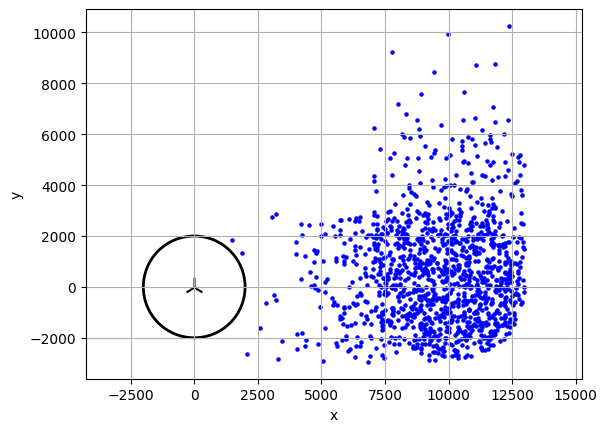

In [142]:
users = leftUpSkewedNormal(K, D, 3000, D, 3000, seed=seed)
print(f'len(users): {len(users)}')
print(f'K: {K}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Mean SE (objective function)
The average achievable spectral efficiency of the relay system over the timeslots is given as
$$\overline{\text{SE}}(\alpha, r, c_\text{x}, c_\text{y}) = \frac{1}{N}\sum_{n=1}^N \min\left[\alpha \cdot \frac{1}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [ ]:
def meanSE(alpha, r, cx, cy, users):
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate SEUA and SEAB
    seua = []
    for n in range(N):
        tmp = np.log2(1.0 + AU/snk0[n])
        seua.append( (alpha/M)*np.sum(tmp) )
    seab = (1-alpha)*np.log2(1.0 + AB/sbn0)

    # Calculate the mins
    min_se = [min(ua, ab) for ua, ab in zip(seua, seab)]

    # Return the average
    return np.mean(min_se)
    


## Baselines
Here I define two baselines to see how much improvement the optimizations are providing us. The two baselines are
1. Running 1000 trials with randomized $\alpha$, $r$, $c_\text{x}$, and $c_\text{y}$ (with $\alpha \in [0, 1]$, $r \in [r_\text{min}, r_\text{max}]$, $c_\text{x} \in [c_\text{xmin}, c_\text{xmax}]$, $c_\text{y} \in [c_\text{ymin}, c_\text{ymax}]$)
2. MeanSE with $\alpha=0.5$, $r=(r_\text{min}+r_\text{max})/2$, $c_\text{x}=\frac{c_\text{xmin} + c_\text{xmax}}{2}$, and $c_\text{y} = \frac{c_\text{ymin} + c_\text{ymax}}{2}$

In [144]:
random_total = 0
for _ in range(1000):
    random_total += meanSE(random.uniform(0, 1), 
                           random.uniform(r_min, r_max), 
                           random.uniform(cx_min, cx_max),
                           random.uniform(cy_min, cy_max),
                           users)

print(f'Random baseline: {random_total / 1000}')

centered_baseline = meanSE(0.5,
                           (r_min + r_max)/2,
                           D/2,
                           0,
                           users)

print(f'Centered baseline: {centered_baseline}')

Random baseline: 0.749438186982489
Centered baseline: 2.5336780144997473


In [174]:
def random_data(iterations=1000):
    """
    Generating random data to make baseline plots
    """

    # average SE achieved by each user
    per_user = np.asarray([0] * K, dtype=float)

    # average SE achieved in each timeslot
    per_timeslot = np.asarray([0] * N, dtype=float)

    for it in range(iterations):
        alpha = random.uniform(0, 1)
        r = random.uniform(r_min, r_max)
        cx = random.uniform(cx_min, cx_max)
        cy = random.uniform(cy_min, cy_max)

        ax = cx + r * cos_th
        ay = cy + r * sin_th

        # Compute squared distances
        snk0 = []
        for n in range(N):
            idxs = np.asarray(Un[n], dtype=int)
            dx = ax[n] - users[idxs, 0]
            dy = ay[n] - users[idxs, 1]
            snk0.append(dx*dx + dy*dy + H*H)
        sbn0 = (ax*ax + ay*ay + H*H)

        # Compute SEUA and SEAB
        seua = []
        for n in range(N):
            seua.append(alpha * np.log2(1 + AU/snk0[n]))
        seab = (1 - alpha) * np.log2(1 + AB/sbn0)

        # Compute per-user achieved SE
        for n in range(N):
            idxs = np.asarray(Un[n], dtype=int)

            timeslot_seua = np.mean(seua[n])

            if (timeslot_seua < seab[n]):
                per_user[idxs] += seua[n]
            else:
                ratio = seab[n] / timeslot_seua
                per_user[idxs] += seua[n] * ratio
        
        # Compute per-timeslot achieved SE
        for n in range(N):
            per_timeslot[n] += min(np.mean(seua[n]), seab[n])
    
    return per_user/iterations, per_timeslot/iterations

def centered_data(iterations=1000, rmin=False):
    """
    Generating centered data to make plots with
    """

    alpha = 0.5
    r = r_min if rmin else (r_min + r_max) / 2
    cx = D/2
    cy = 0

    # Compute UAV position in each timeslot
    ax = cx + r * cos_th
    ay = cy + r * sin_th

    # average SE achieved by each user
    per_user = np.asarray([0] * K, dtype=float)

    # average SE achieved in each timeslot
    per_timeslot = np.asarray([0] * N, dtype=float)

    for it in range(iterations):
        idxs = np.arange(K)
        np.random.shuffle(idxs)
        Un = np.reshape(idxs, (N, M))

        # Compute squared distances
        snk0 = []
        for n in range(N):
            idxs = np.asarray(Un[n], dtype=int)
            dx = ax[n] - users[idxs, 0]
            dy = ay[n] - users[idxs, 1]
            snk0.append(dx*dx + dy*dy + H*H)
        sbn0 = (ax*ax + ay*ay + H*H)

        # Compute SEUA and SEAB
        seua = []
        for n in range(N):
            seua.append(alpha * np.log2(1 + AU/snk0[n]))
        seab = (1-alpha) * np.log2(1 + AB/sbn0)

        # Compute per-user achieved SE
        for n in range(N):
            idxs = np.asarray(Un[n], dtype=int)

            timeslot_seua = np.mean(seua[n])

            if (timeslot_seua < seab[n]):
                per_user[idxs] += seua[n]
            else:
                ratio = seab[n] / timeslot_seua
                per_user[idxs] += seua[n] * ratio
        
        # Compute per-timeslot achieved SE
        for n in range(N):
            per_timeslot[n] += min(np.mean(seua[n]), seab[n])
    
    return per_user/iterations, per_timeslot/iterations


## $\alpha$ Optimizer
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $c_\text{x}$, $c_\text{y}.

In [146]:
def optimize_alpha(r, cx, cy, verbose=False):
    """
    Maximizes the timeshare for a given trajectory

    Returns alpha*
    """

    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute an and bn
    an = []
    for n in range(N):
        tmp = np.log2(1.0 + AU/snk0[n])
        an.append(np.sum(tmp))
    bn = np.log2(1.0 + AB/sbn0)

    alpha_var = cp.Variable()
    tn_var = cp.Variable(N)
    cons = []

    for n in range(N):
        cons += [ tn_var[n] <= (alpha_var / M) * an[n] ]
        cons += [ tn_var[n] <= (1 - alpha_var) * bn[n] ]

    cons += [alpha_var >= 0, alpha_var <= 1]

    obj = cp.Maximize( cp.sum(tn_var) / N )

    prob = cp.Problem(obj, cons)
    prob.solve(solver=cp.MOSEK, verbose=verbose)

    if prob.status not in ("optimal", "optimal_inaccurate"):
        raise RuntimeError(f"SCA subproblem infeasible/failed: status {prob.status}")
    
    return float(alpha_var.value)

## Powell's optimizer for $\alpha$, $r$, $c_\text{x}$, $c_\text{y}$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, $c_\text{x}$, and $c_\text{y}$.

Iteration 0
Optimization terminated successfully.
Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Iteration 4
Optimization terminated successfully.
Iteration 5
Optimization terminated successfully.
Iteration 6
Optimization terminated successfully.
Iteration 7
Optimization terminated successfully.
Iteration 8
Optimization terminated successfully.
Iteration 9
Optimization terminated successfully.
Iteration 10
Optimization terminated successfully.
Iteration 11
Optimization terminated successfully.
Iteration 12
Optimization terminated successfully.
Iteration 13
Optimization terminated successfully.
Optimal alpha: 0.4829973526720046
Optimal radius: 1000.000487879071
Optimal center point: (8374.32141549742, 487.93277295943165)
Achievable SE: 3.1419556335656007


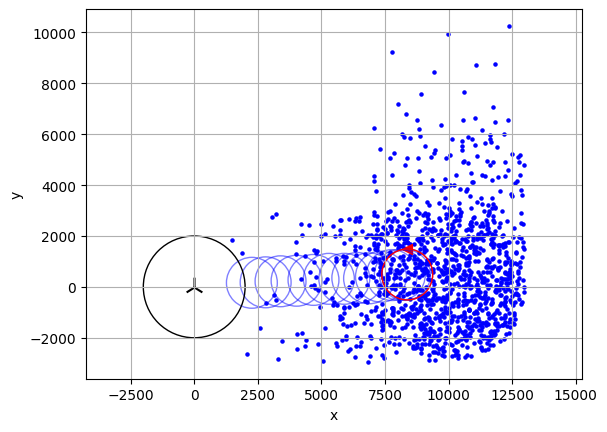

In [147]:
def objective(params, alpha, users):
    r, cx, cy = params
    return -meanSE(alpha, r, cx, cy, users)

def powells_optimizer(
                    alpha0, 
                    r0, 
                    cx0, 
                    cy0, 
                    rbounds,
                    cxbounds,
                    cybounds,
                    users,
                    tolerance=1e-3
):
    # Initialize values
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0
    bounds = [rbounds, cxbounds, cybounds]

    traj_history = []
    obj_history = []

    it = 0
    while True:
        print(f'Iteration {it}')

        alpha = optimize_alpha(r, cx, cy)

        result = minimize(
                    objective,
                    [r,cx,cy],
                    args=(alpha, users),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
        )
        print(result.message)

        r, cx, cy = result.x

        obj_history.append(meanSE(alpha, r, cx, cy, users))
        traj_history.append((r, cx, cy))

        if it > 0:
            if ( (obj_history[-1] - obj_history[-2])/obj_history[-2] < tolerance):
                break
        it += 1
    
    return alpha, traj_history
        
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, traj_hist = powells_optimizer(
                            alpha0, 
                            r0, 
                            cx0, 
                            cy0, 
                            (r_min, r_max),
                            (cx_min, cx_max),
                            (cy_min, cy_max),
                            users)
r_opt, cx_opt, cy_opt = traj_hist[-1]
print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, users)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()


## Successive convex approximation

Optimizer iteration 0
    SCA iteration 0
    SCA iteration 1
    SCA iteration 2
    SCA iteration 3
    SCA iteration 4
    SCA iteration 5
    SCA iteration 6
alpha: 0.49055219966305913, radius: 1000.0000029156977, center: (7919.434620895933, 435.4427067375455)
Optimizer iteration 1
    SCA iteration 0
    SCA iteration 1
alpha: 0.48472740093579436, radius: 1000.0000075895246, center: (8158.963037287516, 448.0676707150708)
Optimizer iteration 2
    SCA iteration 0
    SCA iteration 1
Optimal alpha: 0.4821924529696296
Optimal radius: 1000.0000046294967
Optimal center point: (8310.06493208445, 471.15363160662514)
Achievable SE: 3.1415695854749766


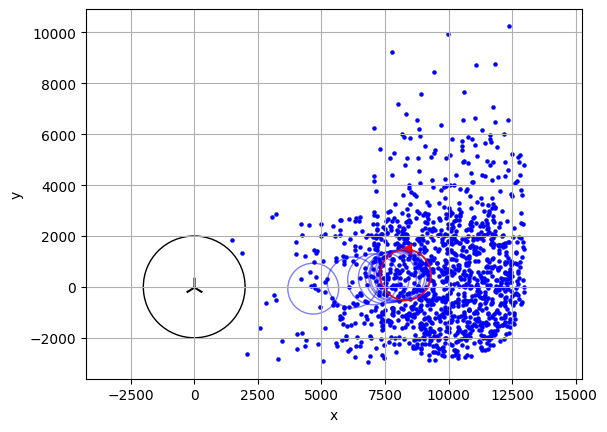

In [148]:
def sca_optimizer(alpha0, 
                r0, 
                cx0, 
                cy0,
                r_bounds, 
                cx_bounds, 
                cy_bounds,
                users,
                sca_tol=1e-3,
                max_sca_iters=30,
                overall_tol=1e-3,
                verbose=False,
):
    
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0

    def f_and_grad(s, A):
        """Return f(s)=log2(1+A/s) and f'(s) = -A/(ln2*s*(s+A)) elementwise."""
        s = np.asarray(s, dtype=float)
        f = 1e4 * np.log2(1.0 + A/np.maximum(s,1e-9))
        fp = 1e4 * -(A) / (np.log(2.0) * np.maximum(s,1e-9) * (np.maximum(s,1e-9) + A))
        return f, fp
    
    traj_hist = []
    overall_obj_hist = []
    overall_it = 0
    while True:
        print(f'Optimizer iteration {overall_it}')

        sca_obj_hist = []
        sca_it = 0

        # r, c optimization
        for sca_it in range(max_sca_iters):
            print(f'    SCA iteration {sca_it}')

            # Compute UAV coords
            ax = cx + r*cos_th
            ay = cy + r*sin_th

            # Compute squared distances
            snk0 = []
            for n in range(N):
                idxs = np.asarray(Un[n], dtype=int)
                dx = ax[n] - users[idxs, 0]
                dy = ay[n] - users[idxs, 1]
                snk0.append(dx*dx + dy*dy + H*H)
            sbn0 = (ax*ax + ay*ay + H*H)            

            # Evaluate f and gradients at current s
            fU0 = []
            gU0 = []
            for n in range(N):
                fu, gu = f_and_grad(snk0[n], AU)
                fU0.append(fu)
                gU0.append(gu )
            fB0, gB0 = f_and_grad(sbn0, AB)

            # CVXPY variables
            r_var  = cp.Variable()
            cx_var = cp.Variable()
            cy_var = cp.Variable()
            t = cp.Variable(N)  # timeslot min-SE terms

            # Auxiliary upper-bounds for squared distances
            s_vars = [cp.Variable(M) for n in range(N)]  # s_{n,k}
            sb_var = cp.Variable(N)  # b^2_n

            cons = []

            # Geometric "upper-bound" constraints: s >= true squared distance
            for n in range(N):
                # planar expressions are affine in (r,cx,cy)
                ax_n = cx_var + r_var*cos_th[n]
                ay_n = cy_var + r_var*sin_th[n]

                # user distances
                idxs = np.asarray(Un[n], dtype=int)
                xk = users[idxs,0]
                yk = users[idxs,1]

                # ||(ax_n - xk, ay_n - yk)||^2 + H^2  <=  s_vars[n]  (as lower-bound on SE we want s_vars >= true)
                # Implement via rotated quadratic cone: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                # In cvxpy, simple convex way is: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                cons += [ s_vars[n] >= (ax_n - xk)**2 + (ay_n - yk)**2 + (H**2) ]

                # AB link
                cons += [ sb_var[n] >= (ax_n)**2 + (ay_n)**2 + (H**2) ]
            
            # Linearized (conservative) SE constraints per slot:
            # t_n <= (alpha/M) sum_k [ fU0 + gU0 * (s - s0) ]
            # t_n <= (1-alpha)      [ fB0 + gB0 * (sb - sb0) ]
            for n in range(N):
                # UA side
                f0 = fU0[n]         # shape (M,)
                g0 = gU0[n]         # shape (M,)
                s0 = snk0[n]       # shape (M,)

                # UA side
                cons += [
                    t[n] <= (alpha/M) * ( cp.sum(f0) + g0 @ (s_vars[n] - s0) )
                ]

                # AB side
                cons += [
                    t[n] <= (1.0 - alpha) * ( fB0[n] + gB0[n] * (sb_var[n] - sbn0[n]) )
                ]
            
            # Add parameter bounds
            r_min, r_max = r_bounds
            cons += [ r_var >= r_min, r_var <= r_max ]
            
            cx_min, cx_max = cx_bounds
            cons += [ cx_var >= cx_min, cx_var <= cx_max ]
            
            cy_min, cy_max = cy_bounds
            cons += [ cy_var >= cy_min, cy_var <= cy_max ]

            # Solve objective
            obj = cp.Maximize( cp.sum(t) / N )
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.MOSEK, verbose=verbose)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                raise RuntimeError(f"    SCA subproblem infeasible/failed at iter {sca_it}: status {prob.status}")
            
            # Update iterate
            r = float(r_var.value)
            cx = float(cx_var.value)
            cy = float(cy_var.value)

            traj_hist.append((r, cx, cy))
            sca_obj_hist.append(float(np.sum(t.value)/N))

            if sca_it > 0:
                # Convergence check (relative improvement in objective)
                if (sca_obj_hist[-1] - sca_obj_hist[-2])/max(1e-9, abs(sca_obj_hist[-2])) < sca_tol:
                    break
        
        # alpha optimization
        alpha = optimize_alpha(r, cx, cy)
        
        overall_obj_hist.append(meanSE(alpha, r, cx, cy, users=users))

        if overall_it > 0:
            if (overall_obj_hist[-1] - overall_obj_hist[-2])/max(1e-9, abs(overall_obj_hist[-2])) < overall_tol:
                break
        
        print(f'alpha: {alpha}, radius: {r}, center: ({cx}, {cy})')
        overall_it += 1
    
    return alpha, traj_hist

alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, traj_hist = sca_optimizer(
                                    alpha0,
                                    r0,
                                    cx0,
                                    cy0,
                                    (r_min, r_max),
                                    (cx_min, cx_max),
                                    (cy_min, cy_max),
                                    users,
                                    verbose=False
)

r_opt, cx_opt, cy_opt = traj_hist[-1]

print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt, users)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)

for traj in traj_hist:
    r, cx, cy = traj
    path = patches.Circle((cx, cy), radius=r, fill=False, color='blue', alpha=0.5, linewidth=1)
    ax.add_patch(path)

ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Super-duper upper bound
For this upper bound, I will calculate the optimal $\alpha$, $c_\text{x}$, and $c_\text{y}$ for a rotary-wing UAV to hover at for each individual user. Then I will find the average spectral efficiency.

In [171]:
def single_user_se(alpha, cx, cy, xk, yk):
    """
    Returns the spectral efficiency achievable by a single user. Note that this 
    assumes that the user has access to the whole bandwidth
    """
    ua = alpha * np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    ab = (1 - alpha) * np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return min(ua, ab)

def single_timeslot_se(alpha, cx, cy, timeslot_users):
    ua = 0.0
    for xk, yk in timeslot_users:
        ua += np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    ua *= (alpha/M)

    ab = (1 - alpha) * np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return min(ua, ab)

def objective_single_user(params, xk, yk):
    cx, cy = params
    
    LU = np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    LB = np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return -LU * LB / (LU + LB)

def objective_single_timeslot(params, timeslot_users):
    cx, cy = params

    LU = 0
    for xk, yk in timeslot_users:
        LU += np.log2(1.0 + AU/( (cx - xk)**2 + (cy - yk)**2 + H**2 ))
    LU /= M

    LB = np.log2(1.0 + AB/( cx**2 + cy**2 + H**2 ))

    return -LU * LB / (LU + LB)

def single_user_rotary_wing(cx0, cy0, xk, yk, tol=1e-3):
    cx_opt, cy_opt = cx0, cy0
    bounds = [(cx_min, cx_max), (cy_min, cy_max)]

    obj_hist = []

    it = 0
    while True:
        result = minimize(
                        objective_single_user,
                        [cx_opt, cy_opt],
                        args=(xk, yk),
                        method='Powell',
                        bounds=bounds,
                        options={
                            'maxiter':1000,
                            'xtol':1e-3,
                            'ftol':1e-3
                        }
        )
        
        cx_opt, cy_opt = result.x

        LU = np.log2(1.0 + AU/( (cx_opt - xk)**2 + (cy_opt - yk)**2 + H**2 ))
        LB = np.log2(1.0 + AB/( cx_opt**2 + cy_opt**2 + H**2 ))

        alpha_opt = LB / (LU + LB)

        obj_hist.append(single_user_se(alpha_opt, cx_opt, cy_opt, xk, yk))

        if it > 0:
            if ( (obj_hist[-1] - obj_hist[-2])/obj_hist[-2] < tol):
                break
                
        it += 1

    return alpha_opt, cx_opt, cy_opt

def single_timeslot_rotary_wing(cx0, cy0, timeslot_users, tol=1e-3):
    cx_opt, cy_opt = cx0, cy0
    bounds = [(cx_min, cx_max), (cy_min, cy_max)]

    obj_hist = []

    it = 0
    while True:
        result = minimize(
                    objective_single_timeslot,
                    [cx_opt, cy_opt],
                    args=(timeslot_users),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
        )

        cx_opt, cy_opt = result.x

        LU = 0
        for xk, yk in timeslot_users:
            LU += np.log2(1.0 + AU/( (cx_opt - xk)**2 + (cy_opt - yk)**2 + H**2 ))
        LU /= M

        LB = np.log2(1.0 + AB/( cx_opt**2 + cy_opt**2 + H**2 ))

        alpha_opt = LB / (LU + LB)

        obj_hist.append(single_timeslot_se(alpha_opt, cx_opt, cy_opt, timeslot_users))

        if it > 0:
            if ( (obj_hist[-1] - obj_hist[-2])/obj_hist[-2] < tol):
                break
        
        it += 1
    
    return alpha_opt, cx_opt, cy_opt

## Upper bound data
Here I will generate data for an upper bound by optimizing a UAV for each user position

In [172]:
def single_user_data():
    """
    Generating upper bound data to make plots with
    """

    # average SE achieved by each user
    per_user = []

    for user in users:
        xk, yk = user
        alpha_opt, cx_opt, cy_opt = single_user_rotary_wing(xk/2, yk/2, xk, yk)
        per_user.append(single_user_se(alpha_opt, cx_opt, cy_opt, xk, yk))
    
    return per_user

def single_timeslot_data(iterations=1000):

    # cx, cy guesses
    cx0 = (cx_min + cx_max)/2
    cy0 = (cy_min + cy_max)/2

    # average SE achieved by each user
    per_user = np.asarray([0.0] * K)

    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)

        # Calculate optimal alpha + position for the given timeslot
        alpha_opt, cx_opt, cy_opt = single_timeslot_rotary_wing(cx0, cy0, users[idxs])
        
        # Calculate SEUA and SEAB for the given timeslot
        seua = []
        for m in range(M):
            xk, yk = users[idxs][m]
            seua.append(alpha_opt * np.log2(1.0 + AU/( (cx_opt-xk)**2 + (cy_opt-yk)**2 + H**2 )))
        seab = (1-alpha_opt) * np.log2(1.0 + AB/( cx_opt**2 + cy_opt**2 + H**2 ))
        
        # Calculate average spectral efficiency achieved over the users
        timeslot_seua = np.mean(seua)

        # If user-UAV is the bottleneck, each user link is the limiting factor
        if (timeslot_seua < seab):
            per_user[idxs] += seua

        # Otherwise, scale the SE of each user by (UAV-BS SE)/(user-UAV SE)
        else:
            ratio = seab / timeslot_seua
            per_user[idxs] += seua / ratio
        
    return per_user


In [167]:
print(single_timeslot_data().mean())

4.096658172279513


# CDF plot

per_user.mean(): 3.141569585474976


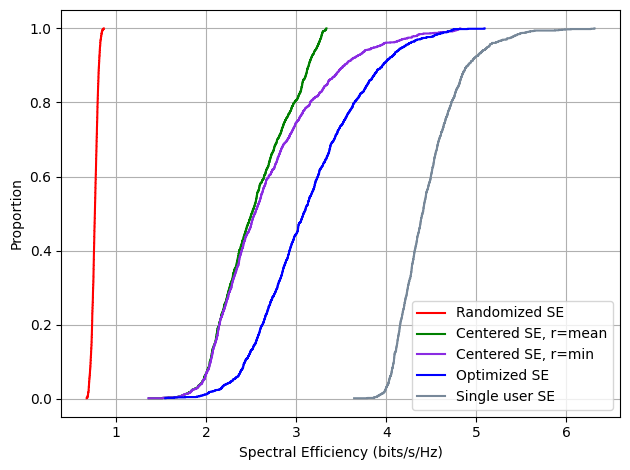

In [ ]:
def cdf(alpha, r, cx, cy, users):
     # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute spectral efficiencies
    seua = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        seua.append(alpha * np.log2(1.0 + AU/snk0[n]))
    seab = (1 - alpha) * np.log2(1.0 + AB/sbn0)

    # Compute SE achieved per user
    per_user = np.asarray([0.0] * K, dtype=float)
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)

        # Average spectral efficiency over all the users
        timeslot_seua = np.mean(seua[n])

        # UAV-BS spectral efficiency
        timeslot_seab = seab[n]

        # If user-UAV SE < UAV-BS SE, each user keeps their SE
        if (timeslot_seua < timeslot_seab):
            per_user[idxs] += seua[n]
        
        # Otherwise, user SEs are scaled by (UAV-BS SE)/(user-UAV SE)
        else:
            ratio = timeslot_seab / timeslot_seua
            per_user[idxs] += seua[n] * ratio
    
    per_user = np.sort(per_user)

    random_per_user, _ = random_data()
    random_per_user = np.sort(random_per_user)

    centered_rmean_per_user, _ = centered_data()
    centered_rmean_per_user = np.sort(centered_rmean_per_user)

    centered_rmin_per_user, _ = centered_data(rmin=True)
    centered_rmin_per_user = np.sort(centered_rmin_per_user)

    single_user_per_user = single_user_data()
    single_user_per_user = np.sort(single_user_per_user)

    # single_timeslot_per_user = single_timeslot_data()
    # single_timeslot_per_user = np.sort(single_timeslot_per_user)

    cdf = np.arange(1, K+1) / K

    plt.plot(random_per_user, cdf, drawstyle="steps-post", label='Randomized SE', c='r')
    plt.plot(centered_rmean_per_user, cdf, drawstyle="steps-post", label='Centered SE, r=mean', c='g')
    plt.plot(centered_rmin_per_user, cdf, drawstyle="steps-post", label='Centered SE, r=min', c='blueviolet')
    plt.plot(per_user, cdf, drawstyle="steps-post", label='Optimized SE', c='b')
    plt.plot(single_user_per_user, cdf, drawstyle="steps-post", label="Single user SE", c='lightslategrey')
    # plt.plot(single_timeslot_per_user, cdf, drawstyle="steps-post", label="Single timeslot SE", c="orange")
    plt.xlabel('Spectral Efficiency (bits/s/Hz)')
    plt.ylabel('Proportion')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

cdf(alpha_opt, r_opt, cx_opt, cy_opt, users)
    

## Variance vs. gain over baselines

In [153]:
def variance_gain():
    variances =  np.arange(2000, 8000, 50)

    alpha0 = 0.5
    r0 = (r_min + r_max)/2
    cx0 = D/2
    cy0 = 0

    optimized = []
    centered = []
    upper_bound = []

    for variance in variances:
        print(f'Variance: {variance}')
        users = np.asarray(leftUpSkewedNormal(K, D, variance, D, variance, seed=seed))

        centered.append(meanSE(
                        alpha0,
                        r_min,
                        cx0,
                        cy0,
                        users))
        
        alpha_opt, traj_hist = powells_optimizer(alpha0,
                                                 r0,
                                                 cx0,
                                                 cy0,
                                                 (r_min, r_max),
                                                 (cx_min, cx_max),
                                                 (cy_min, cy_max),
                                                 users)
        r_opt, cx_opt, cy_opt = traj_hist[-1]

        optimized.append(meanSE(alpha_opt,
                        r_opt,
                        cx_opt,
                        cy_opt,
                        users))
        
        upper_total = 0
        for user in users:
            xk, yk = user
            alpha, cx, cy = single_user_rotary_wing(xk/2, yk/2, xk, yk)
            upper_total += individual_se(alpha, cx, cy, xk, yk)
        
        upper_bound.append(upper_total / K)
        
        
    plt.scatter(variances, optimized, c='g', marker='>', s=5, label='optimized-trajectory')
    plt.scatter(variances, centered, c='r', marker='>', s=5, label='centered-trajectory')
    plt.scatter(variances, upper_bound, c='b', marker='>', s=5, label='upper-bound')
    plt.grid(True)
    plt.xlabel("Variance")
    plt.ylabel("Optimized Spectral Efficiency Gain")
    plt.legend()
    plt.show()        

variance_gain()

Variance: 2000
Iteration 0
Optimization terminated successfully.
Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Iteration 4
Optimization terminated successfully.
Iteration 5
Optimization terminated successfully.
Iteration 6
Optimization terminated successfully.
Iteration 7
Optimization terminated successfully.
Iteration 8
Optimization terminated successfully.
Iteration 9
Optimization terminated successfully.
Variance: 2050
Iteration 0
Optimization terminated successfully.
Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Iteration 4
Optimization terminated successfully.
Iteration 5
Optimization terminated successfully.
Iteration 6
Optimization terminated successfully.
Iteration 7
Optimization terminated successfully.
Iteration 8
Optimization terminated successfully.
Iteration 9
Optimiza

KeyboardInterrupt: 